## Introduction

Here we examine the Chinook.db from the digital record store with tables for artists, albums, media tracks, invoices and customers. There are 11 tables with over 15,000 lines of data.

We will complete a business analysis to see what insights we can uncover utilizing SQL queries.


### SQL Notebook Setup

In [426]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

In [438]:
#Python Libraries for Visualization
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [427]:
%%sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type = "table"

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


### Genre Exploration
First we can explore Genre USA:
- in absolute numbers
- in percentages.

invoice billing_country
invoice_line billing 

In [428]:
%%sql
WITH usa AS(
    SELECT * FROM invoice
    WHERE billing_country = 'USA'
    ),
    usa_tracks AS(
    SELECT *
    FROM usa u
    INNER JOIN invoice_line il ON il.invoice_id = u.invoice_id
    )

SELECT 
    g.name genre, 
    SUM(il.quantity) num_sold, 
    ROUND(SUM(u.total),2) total_sales,
    ROUND((SUM(il.quantity) * 100.0 /
    (
        SELECT SUM(usa_tracks.quantity) from usa_tracks
    )),2) percent_sold
    
FROM usa u
INNER JOIN invoice_line il ON u.invoice_id = il.invoice_id
INNER JOIN track t ON il.track_id = t.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC

 * sqlite:///chinook.db
Done.


genre,num_sold,total_sales,percent_sold
Rock,561,5568.75,53.38
Alternative & Punk,130,1234.53,12.37
Metal,124,1025.64,11.8
R&B/Soul,53,633.6,5.04
Blues,36,453.42,3.43
Alternative,35,369.27,3.33
Pop,22,201.96,2.09
Latin,22,162.36,2.09
Hip Hop/Rap,20,366.3,1.9
Jazz,14,125.73,1.33


### Genre Analysis
Looks like Rock, Alternative & Punk, and Metal are the most popular genres in the USA. 

In terms of data quality, there is another stand alone Alternative genre that we might want to consider combining with Alternative & Punk. Also, is Heavy Metal a subgenre of Metal?

We can continue our exploration and modify the query to find the most popular album in the USA



In [429]:
%%sql
WITH usa AS(
    SELECT * FROM invoice
    WHERE billing_country = 'USA'
    ),
    usa_tracks AS(
    SELECT *
    FROM usa u
    INNER JOIN invoice_line il ON il.invoice_id = u.invoice_id
    )
    
SELECT 
    at.name artist,
    a.title album,
    g.name genre,
    SUM(il.quantity) num_sold, 
    ROUND(SUM(u.total),2) total_sales

FROM usa u
INNER JOIN invoice_line il ON u.invoice_id = il.invoice_id
INNER JOIN track t ON il.track_id = t.track_id
INNER JOIN album a ON a.album_id = t.album_id
INNER JOIN artist at ON a.artist_id = at.artist_id
INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY 2
ORDER BY 5 DESC
LIMIT 5

 * sqlite:///chinook.db
Done.


artist,album,genre,num_sold,total_sales
Marvin Gaye,Seek And Shall Find: More Of The Best (1963-1981),R&B/Soul,26,387.09
Nirvana,From The Muddy Banks Of The Wishkah [live],Rock,28,379.17
Jimi Hendrix,Are You Experienced?,Rock,28,370.26
House Of Pain,House of Pain,Hip Hop/Rap,20,366.3
Eric Clapton,The Cream Of Clapton,Blues,25,358.38


### Album / Artist Recommendation

If we are looking for the top 3 albums to maximize sales, I would use the above query of top albums sorted by Total Sales. There are many ways to try to interpret this data. I decided that from a business sense, Total Sales may be a more important quantity than quantity sold.

- Marvin Gaye - Seek And Shall Find: More Of The Best (1963-1981)
- Nirvana - From The Muddy Banks Of The Wishkah
- Jimi Hendricks - Are You Experienced?	

If we want to see which Artists are the most popular Artists, 
the query can be modified (Sorted by group 1) to show

Van Halen, Eric Clapton, and Nirvana are the 3 most popular artists


### Sales Agent Performance

The following is a query to examine Sales Support Agent performance
The initial request is to look a total amount of sales per each support agent but we will see if there may be any other interesting attributes



In [430]:
%%sql
SELECT e.first_name || ' ' || e.last_name agent_name,
       e.hire_date,
       COUNT(DISTINCT c.customer_id) num_customers,
       ROUND(SUM(i.total), 2) total_dollars,
       SUM(il.quantity) qty_sales,
       ROUND(SUM(i.total)/COUNT(DISTINCT c.customer_id),2) sales_per_customer
FROM customer c
INNER JOIN employee e on c.support_rep_id = e.employee_id
INNER JOIN invoice i on i.customer_id = c.customer_id
INNER JOIN invoice_line il on il.invoice_id = i.invoice_id
GROUP BY 1

 * sqlite:///chinook.db
Done.


agent_name,hire_date,num_customers,total_dollars,qty_sales,sales_per_customer
Jane Peacock,2017-04-01 00:00:00,21,18246.69,1749,868.89
Margaret Park,2017-05-03 00:00:00,20,15923.16,1600,796.16
Steve Johnson,2017-10-17 00:00:00,18,13333.32,1408,740.74


### Additional Analysis
It appears there are only 3 employees. I created a sales/customer metric in addition to adding #of customers and total qty of invoices/sales. I think if we are looking at metrics. we should likely add a time component to this (ie by month or qtr). Total does give us enough actionable information. To provide better metrics, more will have to be known about the business model.

The data seems a little strange. I would have expected much more customers. Each customer seems to be purchasing an avg of 80 tracks - higher than I would have expected

### Country Sales Analysis
Next we will examine the following by Country:
- total number of customers
- total value of sales
- average value of sales per customer
- average order value

We are advised to place all countries with one customer into an Other category so we will tackle that first.

,customers,total_sales,avg_per_customer,avg_order
country,,,,
Czech Republic,2,273.24,136.62,9.11
Portugal,2,185.13,92.57,6.38
India,2,183.15,91.58,8.72
Brazil,5,427.68,85.54,7.01
Germany,4,334.62,83.66,8.16
United Kingdom,3,245.52,81.84,8.77
USA,13,1040.49,80.04,7.94
France,5,389.07,77.81,7.78
Canada,8,535.59,66.95,7.05


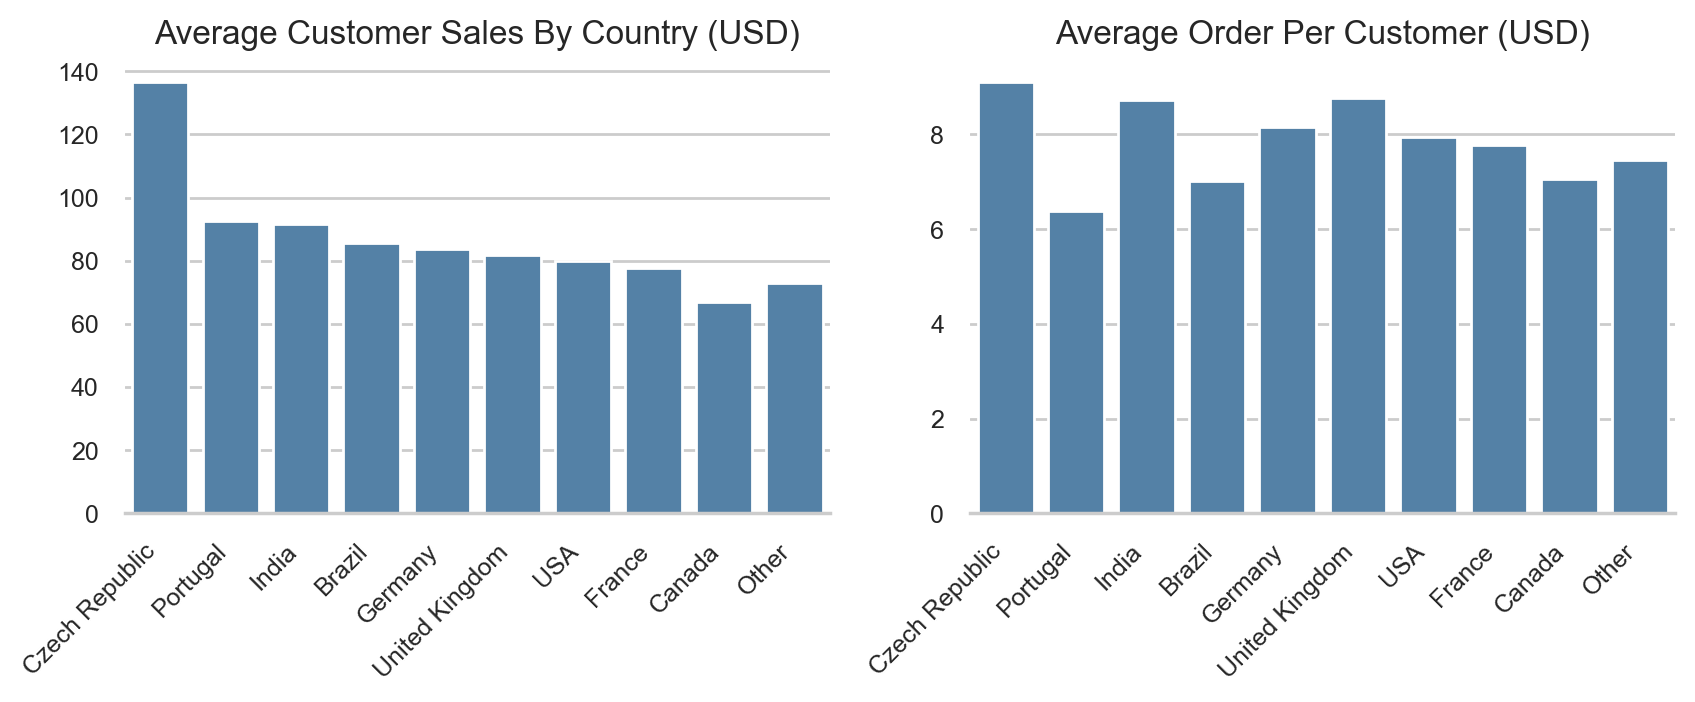

In [508]:
query="""
--create single customer countries with 'Other' 
--retain original country for indexing
WITH filtered_countries AS(
    SELECT
        country,
        CASE
            WHEN COUNT(DISTINCT customer_id) = 1 THEN 'Other'
            ELSE country
        END AS country2
    FROM customer
    GROUP BY country
)

SELECT fc.country2 country,
       COUNT(DISTINCT c.customer_id) customers, 
       ROUND(SUM(i.total),2) total_sales,
       ROUND(SUM(i.total)/COUNT(DISTINCT c.customer_id),2) avg_per_customer,
       ROUND(SUM(i.total)/COUNT(DISTINCT i.invoice_id),2) avg_order
FROM filtered_countries fc
INNER JOIN invoice i ON i.customer_id = c.customer_id
INNER JOIN customer c on c.country = fc.country
GROUP BY fc.country2
ORDER BY fc.country2='Other', avg_per_customer DESC
"""
#Read SQL results into a pandas DataFrame
conn = sqlite3.connect("chinook.db")
df = pd.read_sql_query(query, conn).set_index("country", drop=True)

#Visualize with bar chart
#x-axis labels
fig, ax = plt.subplots(figsize=(10,3))

ax1 = plt.subplot(1,2,1)
ax1 = sns.barplot(x=df.index.tolist(), y='avg_per_customer', data=df, color="steelblue")
ax1.set_title('Average Customer Sales By Country (USD)')
ax1.set_ylabel('')
ax1.tick_params(labelsize=9)
plt.xticks(rotation = 45, ha='right')
sns.despine(left=True)
sns.set(style="whitegrid")

ax2 = plt.subplot(1,2,2)
ax2 = sns.barplot(x=df.index.tolist(), y='avg_order', data=df, color="steelblue")
ax2.set_title('Average Order Per Customer (USD)')
ax2.set_ylabel('')
ax2.tick_params(labelsize=9)
plt.xticks(rotation = 45, ha='right')
sns.despine(left=True)
sns.set(style="whitegrid")

#show the sqlquery result
df

The data shows that it might be worth investing in boosting sales in Czech Republic. India and Portugal also have higher customer spend, but the quantities are so low. In order to make a better decision, other factors will likely need to be considered (size of country etc). This may make India a more attractive target for new customers in order to maximize marketing dollars.


### Album Purchases
Let's take a look at the percentage of album purchases vs individual track invoices.
Can we find any insights as to whether it makes sense to continue selling full albums or only selling individual tracks? We will determine the following:

- Number of Invoices
- Percentage of invoices that are full album purchases.

In [432]:
%%sql
WITH invoice_albums AS(
    --QUERY FOR INVOICE ID/ALBUM ID PAIR
    SELECT 
        il.invoice_id, 
        t.album_id
    FROM invoice_line il
    INNER JOIN track t ON t.track_id = il.track_id
    GROUP BY 1
    )

    ,album_check AS(
    SELECT 
          ia.invoice_id,
          ia.album_id,
          CASE
               WHEN( --album tracks EXCEPT invoice tracks 
               --all album tracks
               (
               SELECT
                   t.track_id
               FROM track t
               INNER JOIN invoice_line il ON il.track_id = t.track_id
               WHERE t.album_id = ia.album_id
               GROUP BY t.track_id
               EXCEPT
               --all invoice trakcs   
               SELECT
                   t.track_id
               FROM track t
               INNER JOIN invoice_line il ON il.track_id = t.track_id
               WHERE il.invoice_id = ia.invoice_id
               GROUP BY t.track_id
               ) IS NULL
-- OPTIONAL SECTION FOR REVERSE EXCEPTION CHECK
--                AND
--                (    
--                SELECT
--                    t.track_id
--                FROM track t
--                INNER JOIN invoice_line il ON il.track_id = t.track_id
--                WHERE il.invoice_id = ia.invoice_id
--                GROUP BY t.track_id
--                EXCEPT
--                SELECT
--                    t.track_id
--                FROM track t
--                INNER JOIN invoice_line il ON il.track_id = t.track_id
--                WHERE t.album_id = ia.album_id
--                GROUP BY t.track_id
--                )IS NULL
               ) 
               THEN 1 --album
               ELSE 0 --individual
           END AS album_purchased
    FROM invoice_albums ia
    )
    
SELECT
    COUNT(*) Total_Invoices,
    TOTAL(album_purchased) Albums_Purchased,
    ROUND(TOTAL(album_purchased)/COUNT(*)*100.0,2) Albums_Purchased_Percent
FROM album_check


 * sqlite:///chinook.db
Done.


Total_Invoices,Albums_Purchased,Albums_Purchased_Percent
614,134.0,21.82


It appears that 20% of the purchases are full album purchases. This shows that there is certainly value to carrying full albums. Perhaps there is some way to determine when full albums should be purchased to maximize efficiency.

## Additional Exploration

- Which artists are the most popular in playlists?
- How many tracks have been purchased vs not purchased?
- Is the range of tracks in the store reflective of their sales popularity?
- Do protected vs non-protected media types have an effect on popularity?

In [433]:
%%sql
WITH playlists AS
    (
    SELECT 
        a.artist_id, 
        t.track_id, 
        pt.playlist_id
    FROM playlist_track pt
    INNER JOIN track t ON t.track_id = pt.track_id
    INNER JOIN album a ON a.album_id = t.album_id
    )

SELECT
    p.artist_id,
    a.name,
    COUNT(DISTINCT p.playlist_id) appearances,
    (
        SELECT COUNT(DISTINCT playlist_id)
        FROM playlists
    ) total_playlists,
    ROUND(COUNT(DISTINCT p.playlist_id)*1.0/
    (
        SELECT COUNT(DISTINCT playlist_id)
        FROM playlists
    ),2) playlist_appearance_pct
FROM playlists p
LEFT JOIN artist a ON a.artist_id = p.artist_id
GROUP BY 1
ORDER BY playlist_appearance_pct DESC
LIMIT 10


 * sqlite:///chinook.db
Done.


artist_id,name,appearances,total_playlists,playlist_appearance_pct
226,Eugene Ormandy,7,14,0.5
248,Berliner Philharmoniker & Herbert Von Karajan,6,14,0.43
247,The King's Singers,6,14,0.43
214,Academy of St. Martin in the Fields & Sir Neville Marriner,6,14,0.43
208,English Concert & Trevor Pinnock,6,14,0.43
275,Philip Glass Ensemble,5,14,0.36
271,"Mela Tenenbaum, Pro Musica Prague & Richard Kapp",5,14,0.36
266,Martin Roscoe,5,14,0.36
265,Julian Bream,5,14,0.36
264,Kent Nagano and Orchestre de l'Opéra de Lyon,5,14,0.36


### Most Popular Artists in Playlists

There are only 14 playlists that cover thousands of tracks. This does not seem to be a very helpful metric.

### Purchase Percentage of All Tracks

In [434]:
%%sql
--QUERY FOR PURCHASED VS UNPURCHASED TRACKS
SELECT 
    COUNT(DISTINCT il.track_id) purchased_tracks,
    COUNT(DISTINCT t.track_id) total_tracks,
    ROUND(100.0*COUNT(DISTINCT il.track_id)/COUNT(DISTINCT t.track_id),2) purchased_pct
FROM track t
LEFT JOIN invoice_line il on t.track_id = il.track_id


 * sqlite:///chinook.db
Done.


purchased_tracks,total_tracks,purchased_pct
1806,3503,51.56


### Protected Media and Purchase Percentage
Do protected vs non-protected media types have an effect on sales?
Let's take a look at the media types first.

In [435]:
%%sql
SELECT DISTINCT(name)
FROM media_type

 * sqlite:///chinook.db
Done.


name
MPEG audio file
Protected AAC audio file
Protected MPEG-4 video file
Purchased AAC audio file
AAC audio file


In [436]:
%%sql
WITH protected AS(
    SELECT DISTINCT *
    FROM media_type
    WHERE name LIKE 'Protected%'
)

SELECT
    COUNT(DISTINCT il.track_id) protected_sold,
    COUNT(DISTINCT t.track_id) protected_total,
    100.0*COUNT(il.track_id)/COUNT(t.track_id) protected_sold_pct
FROM track t
INNER JOIN media_type mt ON mt.media_type_id = t.media_type_id
LEFT JOIN invoice_line il ON il.track_id = t.track_id


 * sqlite:///chinook.db
Done.


protected_sold,protected_total,protected_sold_pct
1806,3503,73.7062286953827


### Observations
Only half of the tracks have been purchased.
When we compare this with the protected tracks at 73% sold, it would seem that DRM does not affect music purchase decisions. I would guess that most of the newer popular tracks are all DRM protected as the industry appears to be moving in this direction.

### Genre & Sales Percentage
With only half of tracks purchased, we should look a little deeper to see how we might improve the efficiency of our store inventory. It might be a good idea to see which genres have more purchased tracks. 

In [513]:
query='''
--QUERY FOR PURCHASED VS UNPURCHASED TRACKS
SELECT
    g.name genre,
    COUNT(DISTINCT il.track_id) tracks_sold,
    COUNT(DISTINCT t.track_id) tracks_total,
    ROUND(100.0*COUNT(DISTINCT il.track_id)/COUNT(DISTINCT t.track_id),2) purchased_pct
FROM track t
LEFT JOIN invoice_line il ON t.track_id = il.track_id
LEFT JOIN genre g ON g.genre_id = t.genre_id
GROUP BY g.name
ORDER BY 4 DESC
'''
#Read Query to Pandas DataFrame
conn = sqlite3.connect('chinook.db')
df = pd.read_sql_query(query, conn)#.set_index('genre',drop=True)
df

,genre,tracks_sold,tracks_total,purchased_pct
0,Easy Listening,24,24,100.00
1,Electronica/Dance,29,30,96.67
2,R&B/Soul,55,61,90.16
3,Alternative,34,40,85.00
4,Rock,915,1297,70.55
5,Blues,56,81,69.14
6,Metal,238,374,63.64
7,Hip Hop/Rap,21,35,60.00
8,Alternative & Punk,176,332,53.01
9,Pop,25,48,52.08


In [537]:
#Genre Sales% Visualization

df['genre'] = df['genre'].mask(df['tracks_sold'] <10, 'Other')
genres = df.groupby('genre').sum()
genres = genres.sort_values(by='tracks_sold', ascending=False)
tracks_sold = genre.tracks_sold
tracks_sold

genre
Rock                  915
Metal                 238
Alternative & Punk    176
Latin                 119
Jazz                   61
Blues                  56
R&B/Soul               55
Alternative            34
Electronica/Dance      29
Pop                    25
Easy Listening         24
Reggae                 22
Hip Hop/Rap            21
Classical              16
Other                  15
Name: tracks_sold, dtype: int64

Text(0, 0.5, '')

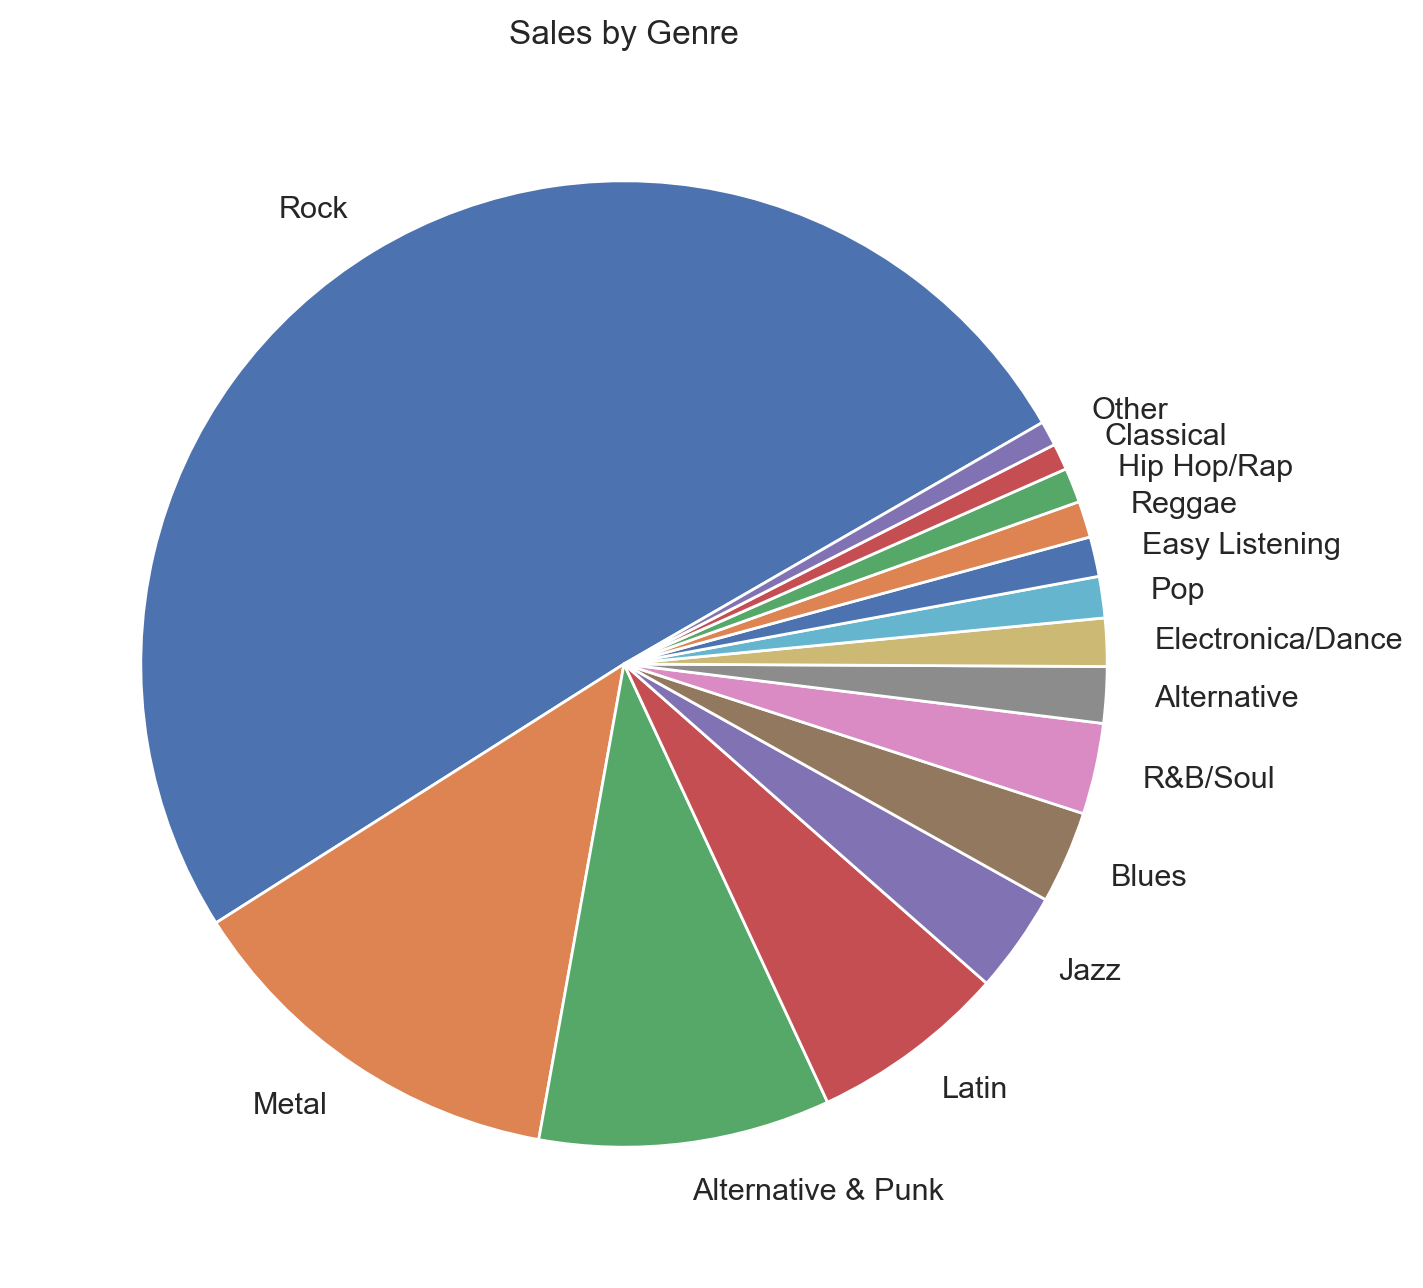

In [536]:
fig, ax = plt.subplots(figsize=(8,8))
tracks_sold.plot(kind='pie', startangle=30)
ax.set_title('Sales by Genre')
ax.set_ylabel('')

### Purchased Tracks by Genre
A look into genre reveals some insight for future inventory updates.
We should consider reducing the inventory from unpopular genres and increasing inventory for the genres at the top of the table.

More tracks should be acquired for Easy Listening, Eletronica/Dance, R&B/Soul, and Alternative.
